In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook

In [2]:
from matplotlib import font_manager,rc
import matplotlib
import platform

if platform.system() == 'Windows':
    path = 'c:/windows/Fonts/malgun.ttf'
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font',family = font_name)
elif platform.system() == 'Darwin':
    rc('font',family = 'AppleGothic')
else:
    print('Check your OS system')
    
matplotlib.rcParams['axes.unicode_minus'] = False

In [3]:
df = pd.read_excel('중간.xlsx')

# 범주형 변수의 처리
- title,genre,country,rating,companyNm,running_time_bins,감독
- genre, country, companyNm, 감독, rating, running_time_bins

In [4]:
# genre, country, companyNm, 감독, rating
categorical_vars = ['title','genre','country','rating','companyNm','running_time_bins','감독']

## rating
각 그림을 그릴 것

In [5]:
df['rating'].value_counts()

15세이상관람가    540
12세이상관람가    365
청소년관람불가     267
전체관람가       239
Name: rating, dtype: int64

In [6]:
df.groupby('rating').agg(['count','mean','min','max'])['log_num_viewers']

,count,mean,min,max
rating,,,,
12세이상관람가,365,13.177764,10.219794,16.483498
15세이상관람가,540,12.899662,10.470845,16.684187
전체관람가,239,12.720050,10.025749,16.147276
청소년관람불가,267,12.488422,10.487991,15.771657


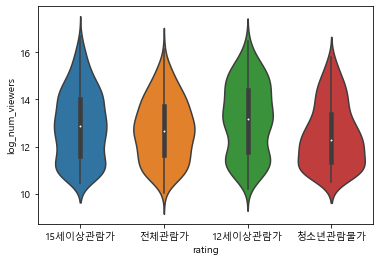

In [7]:
# label encoding을 하기에는 전체->12세->15세->청불로의 어떤 순서가 보이지는 않음
sns.violinplot(x=df['rating'],y=df['log_num_viewers'])
plt.show()

In [8]:
# 마찬가지로 모두 정규분포라 보기 어려움
from scipy.stats import shapiro
for rate in np.unique(df['rating']):
    print(shapiro(df.loc[df['rating']==rate,'log_num_viewers']))

ShapiroResult(statistic=0.9669740796089172, pvalue=2.376284840011067e-07)
ShapiroResult(statistic=0.9691852927207947, pvalue=3.1569105107820405e-09)
ShapiroResult(statistic=0.9793404340744019, pvalue=0.0014666200149804354)
ShapiroResult(statistic=0.9464811086654663, pvalue=2.6605075476027196e-08)


In [9]:
# rate별로 응답변수의 차이가 있어보임
from scipy.stats import kruskal
test_list = [df.loc[df['rating']==rate,'log_num_viewers'] for rate in np.unique(df['rating'])]
kruskal(test_list[0],test_list[1],test_list[2],test_list[3])

KruskalResult(statistic=35.38100099984821, pvalue=1.0121167193226453e-07)

사후 분석을 해보려했으나 정규성 가정을 만족하지 않는 경우의 사후분석에 관한 라이브러리 미설치로 수행하지 못함<br>
어느 하나만이라도 영향이 있다면 해당 변수에 coeff를 크게 줄 수 있도록 one-hot encoding을 사용하기로 결정

## genre

In [10]:
# 너무 많으므로 비슷한 종류끼리 통합이 필요해보임
df['genre'].value_counts()

드라마         306
액션          270
애니메이션       173
코미디         137
멜로/로맨스       92
범죄           70
공포(호러)       69
스릴러          63
SF           58
미스터리         35
어드벤처         31
사극           31
판타지          28
다큐멘터리        22
가족           14
전쟁            7
뮤지컬           3
서부극(웨스턴)      2
Name: genre, dtype: int64

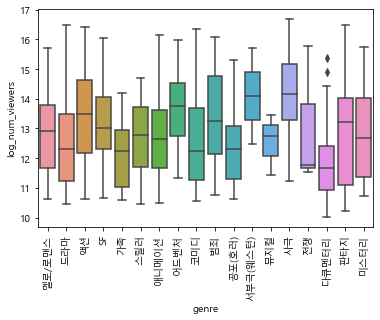

In [8]:
sns.boxplot(x = df['genre'],y = df['log_num_viewers'])
plt.xticks(rotation=90)
plt.show()

In [10]:
# dummy변수로 만들고 pca 적용 후 설명력 체크
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
pca = PCA()
genre = pd.get_dummies(df['genre'])
# mean_centering
pca.fit(genre)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

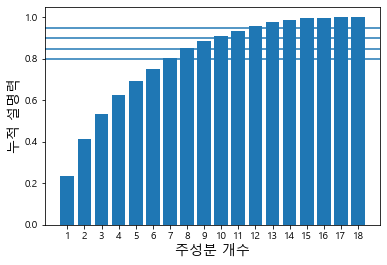

In [14]:
# 85%를 설명하는 8개의 components를 사용 
plt.bar(range(len(pca.explained_variance_ratio_)),np.cumsum(pca.explained_variance_ratio_))
plt.xticks(range(len(pca.explained_variance_ratio_)),labels = list(range(1,len(pca.explained_variance_ratio_)+1)))
plt.axhline(0.95)
plt.axhline(0.9)
plt.axhline(0.85)
plt.axhline(0.8)
plt.xlabel('주성분 개수',fontsize=14)
plt.ylabel('누적 설명력',fontsize=14)
plt.show()

## country

In [11]:
df['country'].value_counts()

미국          675
한국          482
일본           72
영국           45
프랑스          40
중국           23
독일           11
스페인          11
홍콩           11
벨기에           7
캐나다           5
인도            5
호주            4
이탈리아          4
대만            2
덴마크           2
남아프리카공화국      2
스웨덴           2
뉴질랜드          2
멕시코           1
러시아           1
아이슬란드         1
페루            1
오스트리아         1
아일랜드          1
Name: country, dtype: int64

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24]),
 <a list of 25 Text xticklabel objects>)

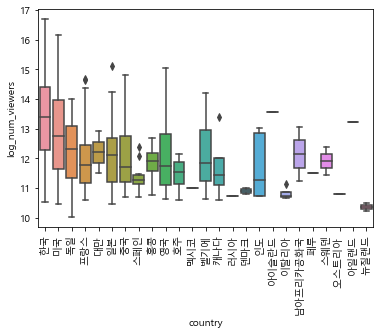

In [12]:
sns.boxplot(x = df['country'],y = df['log_num_viewers'])
plt.xticks(rotation=90)

In [13]:
# 한국, 미국, 기타 범주로 묶기로 한다.
cond1 = df['country']!='한국'
cond2 = df['country']!='미국'
df.loc[cond1&cond2,'country'] = '기타'

In [14]:
# 다음 정보를 원핫 인코딩 하도록 한다.
df['country'].value_counts()

미국    675
한국    482
기타    254
Name: country, dtype: int64

## 감독
다음 사이트에 언급된 정도를 믿고 보는 감독의 정도(수치)로 취급<br>
날짜이므로 각 년도별 정보를 취합(크롤링)<br>
https://movie.naver.com/movie/sdb/rank/rpeople.naver?date=20220329&tg=2<br>
해당 사이트는 2005년 2월 7일 이전의 정보는 집계하지 않았다. 우리가 가진 데이터셋은 2005년에 하나 이후로 2008년 영화 데이터만 있으므로 2005년도는 무시하도록 한다.

In [15]:
df['released_year']

0       2011
1       2005
2       2010
3       2008
4       2016
        ... 
1406    2017
1407    2017
1408    2017
1409    2017
1410    2018
Name: released_year, Length: 1411, dtype: int64

In [16]:
# 일단 다음 감독 이름을 일치시키도록 한다.
df.loc[df['감독'].str.contains('J.J'),'감독']

201    J.J. 에이브럼스
352    J.J. 에이브럼스
457    J.J. 에이브람스
618    J.J. 에이브럼스
Name: 감독, dtype: object

In [17]:
df.loc[df['감독'].str.contains('J.J'),'감독'] = 'J.J. 에이브람스'

In [57]:
from bs4 import BeautifulSoup
import requests

In [58]:
searching_year = list(np.unique(df['released_year']))
searching_year.remove(2005)

searching_month = list(np.unique(df['released_month']))
# 2월 29일은 무시
searching_day = [31,28,31,30,31,30,31,31,30,31,30,31]

In [59]:
df['released_month']

0        2
1       11
2        4
3       11
4        1
        ..
1406     8
1407     4
1408     8
1409    11
1410     8
Name: released_month, Length: 1411, dtype: int64

In [60]:
df['감독 순위'] = np.zeros_like(df['감독'])

In [61]:
backup_df = df

In [62]:
df = backup_df

In [256]:
all_eval_df = pd.DataFrame()
for year in tqdm_notebook(searching_year):
    for month in searching_month:
        for day in range(1,searching_day[month-1]+1):
            url = 'https://movie.naver.com/movie/sdb/rank/rpeople.naver?tg=2&date=' + str(year)+str(month).zfill(2) + str(day).zfill(2)
            html = requests.get(url)
            soup = BeautifulSoup(html.text, 'html.parser')
            directors = list(map(lambda x:x.text.strip().split(' (')[0],soup.select('td.title')))
            temp_df = pd.DataFrame(directors,columns = ['director'])
            temp_df['rank'] = temp_df.index+1
            all_eval_df = all_eval_df.append(temp_df)
            all_eval_df.reset_index(inplace = True, drop=True)
        # 월별로 누적 --> 매해 축척된 평가가 반영됨(최근 순위에 가중치는 부여하지 않음)
        yearmonth_rank = all_eval_df.groupby('director').mean()
        cond1 = df['released_year'] == year
        cond2 = df['released_month'] == month

        searched_directors = np.intersect1d(yearmonth_rank.index, df.loc[(cond1&cond2),'감독'], return_indices=True)
        temp_dict = dict(zip(searched_directors[0],list(yearmonth_rank.iloc[searched_directors[1]].values[:,0])))
        df.loc[cond1&cond2,'감독 순위'] = df.loc[cond1&cond2,'감독'].map(temp_dict)

In [15]:
cond = df['감독 순위'] < sys.float_info.epsilon
df.loc[cond,'감독 순위'] = np.nan

In [21]:
df.to_excel('중간2.xlsx',index=False)

In [22]:
df = pd.read_excel('중간2.xlsx')

## 감독 순위의 의미가 있는지

In [31]:
analysis_drop = df.dropna(subset=['감독 순위'])
for i in range(1,6):
    print(f"{i}\n{np.corrcoef([analysis_drop['감독 순위']**(i),analysis_drop['log_num_viewers'],analysis_drop['num_viewers']])}")

1
[[ 1.         -0.18426468 -0.14238597]
 [-0.18426468  1.          0.75930792]
 [-0.14238597  0.75930792  1.        ]]
2
[[ 1.         -0.21444192 -0.16619464]
 [-0.21444192  1.          0.75930792]
 [-0.16619464  0.75930792  1.        ]]
3
[[ 1.         -0.2315163  -0.17451584]
 [-0.2315163   1.          0.75930792]
 [-0.17451584  0.75930792  1.        ]]
4
[[ 1.         -0.23916352 -0.17295342]
 [-0.23916352  1.          0.75930792]
 [-0.17295342  0.75930792  1.        ]]
5
[[ 1.         -0.23861319 -0.16408905]
 [-0.23861319  1.          0.75930792]
 [-0.16408905  0.75930792  1.        ]]


상관계수가 낮기는 하지만 0.24까지 나오므로 네제곱한 데이터를 사용해보기로 한다.<br>
결측치 데이터는 감독의 이름 효과를 못 받은 경우로 생각하기 위해 0으로 만들고 큰값과 작은값의 의미를 명확하게 하기 위해 나머지 값들에 대해서는 min, max를 바꿔주도록 한다.

In [32]:
df['감독 순위'].max(), df['감독 순위'].min()

(40.0, 1.0)

In [33]:
df['감독 순위'] = -1*(df['감독 순위'] - df['감독 순위'].max() - df['감독 순위'].min())
df['감독 순위'].fillna(0,inplace = True)
df['감독 순위'] = df['감독 순위'] ** 4
df.to_excel('중간3.xlsx',index=False)

In [35]:
df = pd.read_excel('중간3.xlsx')

## companyNm

In [23]:
df['companyNm'].value_counts()

롯데쇼핑㈜롯데엔터테인먼트          163
씨제이이앤엠(주)              124
유니버설픽쳐스인터내셔널 코리아(유)    100
워너브러더스 코리아(주)           88
이십세기폭스코리아(주)            85
                      ... 
(주)레드로버                  1
(주)모인그룹                  1
(유)조이앤시네마                1
(주)인디플러그                 1
(주)콘텐츠판다                 1
Name: companyNm, Length: 132, dtype: int64

In [24]:
# 배급사 수가 너무 많으므로 전체 20% 미만()을 차지하는 군소 배급사는 '기타' 범주로 통합 

print(df.shape[0]/5)
print(f"통합대상 데이터 수 : {df['companyNm'].value_counts()[df['companyNm'].value_counts() <= 11].sum()}")
print(f"남는 배급사 : {len(df['companyNm'].value_counts()[df['companyNm'].value_counts() > 11])+1}")

282.2
통합대상 데이터 수 : 281
남는 배급사 : 28


In [25]:
small_companies = list(df['companyNm'].value_counts()[df['companyNm'].value_counts() <= 11].index)
df['companyNm_integrated'] = df['companyNm'].map(lambda x:'Etc' if x in small_companies else x)

In [26]:
df['companyNm_integrated'].value_counts().head()

Etc                    281
롯데쇼핑㈜롯데엔터테인먼트          163
씨제이이앤엠(주)              124
유니버설픽쳐스인터내셔널 코리아(유)    100
워너브러더스 코리아(주)           88
Name: companyNm_integrated, dtype: int64

In [27]:
df.groupby('companyNm_integrated').agg(['count','mean','min','max','var'])['log_num_viewers']

,count,mean,min,max,var
companyNm_integrated,,,,,
(주)나이너스엔터테인먼트,14,12.006288,10.681963,13.731950,0.911015
(주)넥스트엔터테인먼트월드(NEW),82,13.383540,10.627358,16.365831,2.006605
(주)리틀빅픽쳐스,12,11.897503,10.597659,15.003428,1.879322
(주)쇼박스,78,13.666003,10.599057,16.315855,2.294908
(주)시너지하우스 (시너지),27,12.295813,10.712282,14.469207,1.203176
(주)시네마서비스,13,12.952833,10.838737,15.274282,1.597887
(주)싸이더스,27,12.353408,10.675492,15.205638,1.028005
(주)영화사 빅,15,11.465292,10.631447,12.393104,0.303854
(주)이수C&E,15,11.856831,10.553362,13.236804,0.784812


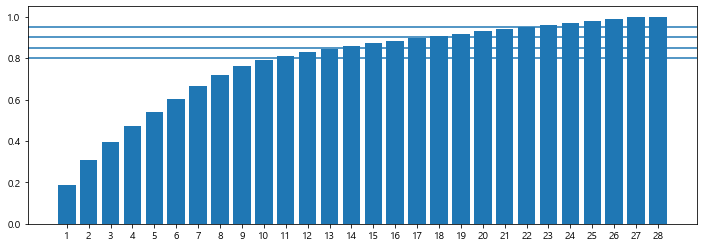

In [28]:
# 마찬가지로 85% 수준에서 선택
from sklearn.decomposition import PCA
pca = PCA()
country = pd.get_dummies(df['companyNm_integrated'])
pca.fit(country)

plt.figure(figsize = (12,4))
plt.bar(range(len(pca.explained_variance_ratio_)),np.cumsum(pca.explained_variance_ratio_))
plt.xticks(range(len(pca.explained_variance_ratio_)),labels = list(range(1,len(pca.explained_variance_ratio_)+1)))
plt.axhline(0.95)
plt.axhline(0.9)
plt.axhline(0.85)
plt.axhline(0.8)

## month

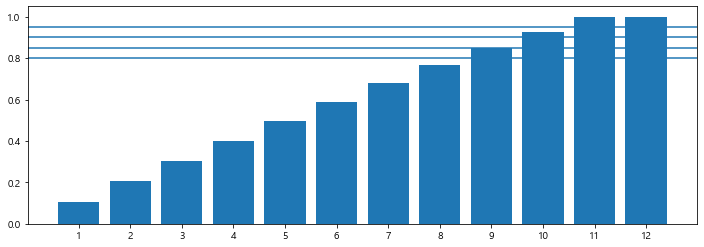

In [37]:
# 차원축소가 거의 의미가 없어보이므로 전부를 사용
from sklearn.decomposition import PCA
pca = PCA()
month = pd.get_dummies(df['released_month'])
pca.fit(month)

plt.figure(figsize = (12,4))
plt.bar(range(len(pca.explained_variance_ratio_)),np.cumsum(pca.explained_variance_ratio_))
plt.xticks(range(len(pca.explained_variance_ratio_)),labels = list(range(1,len(pca.explained_variance_ratio_)+1)))
plt.axhline(0.95)
plt.axhline(0.9)
plt.axhline(0.85)
plt.axhline(0.8)